In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))
import numpy as np
import pandas as pd
import cmdstanpy
from utils.random import simulate_ANNRDM_individual
from utils.utils import get_parameters_range, get_stan_parameters, save_results_to_csv, plot_parameter_recovery_results

In [2]:
root = "../"
plots_root = "Results/individual/Plots/"
datasets_root = root + "Datasets/"
behavioural_data_root = datasets_root +  "behavioral_data/selected_data/" 

dataset_path = datasets_root + "AI Models Results/fastText_FC.csv"

In [3]:
word_nword_df = pd.read_csv(dataset_path, header=None,
                            names =["string", "freq",  "label", "zipf",
                                    "category", "word_prob", "non_word_prob"])

In [4]:
number_of_participants = 3
n_trials = 400

# set sampling parameters
n_iter = 500
n_warmup = int(n_iter/2)
n_sample = int(n_iter/2)
n_chains = 2

priors = {
    'threshold_priors': [2, 1],
    'ndt_priors': [0, 1],
    'alpha_priors': [0, 1],
    'b_priors': [0, 1],
    'k_priors': [2, 1] 
}

params_range = pd.read_csv("Data/params_range.csv", index_col=0)

In [5]:
def paremeter_recovery(params=['k_2', 'k_1', 'b', 'alpha', 'threshold_word', 'threshold_nonword', 'ndt']):
    for param in params:
        print(f"Starting recovery for {param} parameter")
        
        stan_file_path = f'{root}/models/stan/ANN-RDM/individual/{param}_recovery.stan'
        model_name = f'{param}_pr'
        
        rdm_model = cmdstanpy.CmdStanModel(model_name=model_name,
                                   stan_file=stan_file_path)
        
        iteration_count = 0
        while iteration_count < number_of_participants:
            print(f"Iteration for participant {iteration_count+1} Started")
            parameters_set = params_range.copy()
            parameters_set["generated"] = np.random.normal(loc=parameters_set.iloc[:, 0],
                                                           scale=parameters_set.iloc[:, 1])

            behavioral_df = simulate_ANNRDM_individual(n_trials=n_trials, trials_info_df=word_nword_df,
                                                 parameters_set=parameters_set)
            stan_parameters = get_stan_parameters(behavioral_df, priors)
            fit = rdm_model.sample(data=stan_parameters,
                               iter_sampling=n_sample, 
                               iter_warmup=n_warmup,
                               chains=n_chains,
                               show_console=False)

            df = fit.summary()
            badRhat = False
            for f in df["R_hat"]:
                if f >= 1.01 or f <= 0.9:
                    badRhat = True

            if badRhat:
                print("Split R-hat values are not satisfactory for all parameters. repeating iteration") 
            else:
                save_results_to_csv(fit, parameters_set, param)
                print(f"Iteration for participant {iteration_count+1} Finished") 
                iteration_count += 1
                
        plot_parameter_recovery_results(param_name=param)
        
        print(f"Finished recovery for {param} parameter")

Starting recovery for k_2 parameter
Iteration for participant 1 Started


13:44:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:44:52 - cmdstanpy - INFO - CmdStan done processing.



Iteration for participant 1 Finished
Iteration for participant 2 Started


13:44:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:44:59 - cmdstanpy - INFO - CmdStan done processing.



Split R-hat values are not satisfactory for all parameters. repeating iteration
Iteration for participant 2 Started


13:45:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:45:06 - cmdstanpy - INFO - CmdStan done processing.



Iteration for participant 2 Finished
Iteration for participant 3 Started


13:45:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:45:14 - cmdstanpy - INFO - CmdStan done processing.



Iteration for participant 3 Finished
Finished recovery for k_2 parameter
Starting recovery for k_1 parameter
Iteration for participant 1 Started


13:45:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:45:21 - cmdstanpy - INFO - CmdStan done processing.



Split R-hat values are not satisfactory for all parameters. repeating iteration
Iteration for participant 1 Started


13:45:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:45:27 - cmdstanpy - INFO - CmdStan done processing.



Iteration for participant 1 Finished
Iteration for participant 2 Started


13:45:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:45:35 - cmdstanpy - INFO - CmdStan done processing.



Iteration for participant 2 Finished
Iteration for participant 3 Started


13:45:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:45:42 - cmdstanpy - INFO - CmdStan done processing.



Iteration for participant 3 Finished
Finished recovery for k_1 parameter
Starting recovery for b parameter
Iteration for participant 1 Started


13:45:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:45:51 - cmdstanpy - INFO - CmdStan done processing.
13:45:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: b_recovery_model_namespace::log_prob: drift_word_t[2] is nan, but must be greater than or equal to 0.000000 (in 'E:/Workspace/Thesis/ANN-EAM/models/stan/ANN-RDM/individual/b_recovery.stan', line 86, column 4 to column 36)
Consider re-running with show_console=True if the above output is unclear!



Split R-hat values are not satisfactory for all parameters. repeating iteration
Iteration for participant 1 Started


13:45:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:45:58 - cmdstanpy - INFO - CmdStan done processing.
13:45:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: b_recovery_model_namespace::log_prob: drift_word_t[1] is nan, but must be greater than or equal to 0.000000 (in 'E:/Workspace/Thesis/ANN-EAM/models/stan/ANN-RDM/individual/b_recovery.stan', line 86, column 4 to column 36)
Consider re-running with show_console=True if the above output is unclear!



Split R-hat values are not satisfactory for all parameters. repeating iteration
Iteration for participant 1 Started


13:46:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:46:06 - cmdstanpy - INFO - CmdStan done processing.
13:46:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: b_recovery_model_namespace::log_prob: drift_word_t[1] is nan, but must be greater than or equal to 0.000000 (in 'E:/Workspace/Thesis/ANN-EAM/models/stan/ANN-RDM/individual/b_recovery.stan', line 86, column 4 to column 36)
Consider re-running with show_console=True if the above output is unclear!



Split R-hat values are not satisfactory for all parameters. repeating iteration
Iteration for participant 1 Started


13:46:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:46:12 - cmdstanpy - INFO - CmdStan done processing.
13:46:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: b_recovery_model_namespace::log_prob: drift_word_t[2] is nan, but must be greater than or equal to 0.000000 (in 'E:/Workspace/Thesis/ANN-EAM/models/stan/ANN-RDM/individual/b_recovery.stan', line 86, column 4 to column 36)
Consider re-running with show_console=True if the above output is unclear!



Iteration for participant 1 Finished
Iteration for participant 2 Started


13:46:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:46:20 - cmdstanpy - INFO - CmdStan done processing.
13:46:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: b_recovery_model_namespace::log_prob: drift_word_t[5] is nan, but must be greater than or equal to 0.000000 (in 'E:/Workspace/Thesis/ANN-EAM/models/stan/ANN-RDM/individual/b_recovery.stan', line 86, column 4 to column 36)
Exception: b_recovery_model_namespace::log_prob: drift_word_t[5] is nan, but must be greater than or equal to 0.000000 (in 'E:/Workspace/Thesis/ANN-EAM/models/stan/ANN-RDM/individual/b_recovery.stan', line 86, column 4 to column 36)
Consider re-running with show_console=True if the above output is unclear!



Iteration for participant 2 Finished
Iteration for participant 3 Started


13:46:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:46:29 - cmdstanpy - INFO - CmdStan done processing.
13:46:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: b_recovery_model_namespace::log_prob: drift_word_t[3] is nan, but must be greater than or equal to 0.000000 (in 'E:/Workspace/Thesis/ANN-EAM/models/stan/ANN-RDM/individual/b_recovery.stan', line 86, column 4 to column 36)
Consider re-running with show_console=True if the above output is unclear!



Split R-hat values are not satisfactory for all parameters. repeating iteration
Iteration for participant 3 Started


13:46:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:46:37 - cmdstanpy - INFO - CmdStan done processing.



Split R-hat values are not satisfactory for all parameters. repeating iteration
Iteration for participant 3 Started


13:46:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:46:43 - cmdstanpy - INFO - CmdStan done processing.



Iteration for participant 3 Finished
Finished recovery for b parameter
Starting recovery for alpha parameter
Iteration for participant 1 Started


13:46:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:46:52 - cmdstanpy - INFO - CmdStan done processing.



Split R-hat values are not satisfactory for all parameters. repeating iteration
Iteration for participant 1 Started


13:46:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:46:59 - cmdstanpy - INFO - CmdStan done processing.



Split R-hat values are not satisfactory for all parameters. repeating iteration
Iteration for participant 1 Started


13:47:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:47:07 - cmdstanpy - INFO - CmdStan done processing.



Split R-hat values are not satisfactory for all parameters. repeating iteration
Iteration for participant 1 Started


13:47:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:47:15 - cmdstanpy - INFO - CmdStan done processing.



Split R-hat values are not satisfactory for all parameters. repeating iteration
Iteration for participant 1 Started


13:47:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:47:23 - cmdstanpy - INFO - CmdStan done processing.



Split R-hat values are not satisfactory for all parameters. repeating iteration
Iteration for participant 1 Started


13:47:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:47:31 - cmdstanpy - INFO - CmdStan done processing.



Iteration for participant 1 Finished
Iteration for participant 2 Started


13:47:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:47:39 - cmdstanpy - INFO - CmdStan done processing.



Iteration for participant 2 Finished
Iteration for participant 3 Started


13:47:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:47:49 - cmdstanpy - INFO - CmdStan done processing.



Split R-hat values are not satisfactory for all parameters. repeating iteration
Iteration for participant 3 Started


13:47:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:47:57 - cmdstanpy - INFO - CmdStan done processing.



Iteration for participant 3 Finished
Finished recovery for alpha parameter
Starting recovery for threshold_word parameter
Iteration for participant 1 Started


13:48:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:48:07 - cmdstanpy - INFO - CmdStan done processing.



Split R-hat values are not satisfactory for all parameters. repeating iteration
Iteration for participant 1 Started


13:48:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:48:16 - cmdstanpy - INFO - CmdStan done processing.



Split R-hat values are not satisfactory for all parameters. repeating iteration
Iteration for participant 1 Started


13:48:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:48:25 - cmdstanpy - INFO - CmdStan done processing.



Split R-hat values are not satisfactory for all parameters. repeating iteration
Iteration for participant 1 Started


13:48:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:48:35 - cmdstanpy - INFO - CmdStan done processing.



Split R-hat values are not satisfactory for all parameters. repeating iteration
Iteration for participant 1 Started


13:48:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:48:45 - cmdstanpy - INFO - CmdStan done processing.



Split R-hat values are not satisfactory for all parameters. repeating iteration
Iteration for participant 1 Started


13:48:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:48:54 - cmdstanpy - INFO - CmdStan done processing.



Iteration for participant 1 Finished
Iteration for participant 2 Started


13:49:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:49:04 - cmdstanpy - INFO - CmdStan done processing.



Iteration for participant 2 Finished
Iteration for participant 3 Started


13:49:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:49:14 - cmdstanpy - INFO - CmdStan done processing.



Iteration for participant 3 Finished
Finished recovery for threshold_word parameter
Starting recovery for threshold_nonword parameter
Iteration for participant 1 Started


13:49:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:49:24 - cmdstanpy - INFO - CmdStan done processing.



Split R-hat values are not satisfactory for all parameters. repeating iteration
Iteration for participant 1 Started


13:49:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:49:32 - cmdstanpy - INFO - CmdStan done processing.



Iteration for participant 1 Finished
Iteration for participant 2 Started


13:49:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:49:43 - cmdstanpy - INFO - CmdStan done processing.



Iteration for participant 2 Finished
Iteration for participant 3 Started


13:49:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:49:54 - cmdstanpy - INFO - CmdStan done processing.



Iteration for participant 3 Finished
Finished recovery for threshold_nonword parameter
Starting recovery for ndt parameter
Iteration for participant 1 Started


13:50:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:50:04 - cmdstanpy - INFO - CmdStan done processing.



Split R-hat values are not satisfactory for all parameters. repeating iteration
Iteration for participant 1 Started


13:50:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:50:13 - cmdstanpy - INFO - CmdStan done processing.



Iteration for participant 1 Finished
Iteration for participant 2 Started


13:50:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:50:22 - cmdstanpy - INFO - CmdStan done processing.



Split R-hat values are not satisfactory for all parameters. repeating iteration
Iteration for participant 2 Started


13:50:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:50:30 - cmdstanpy - INFO - CmdStan done processing.



Iteration for participant 2 Finished
Iteration for participant 3 Started


13:50:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:50:39 - cmdstanpy - INFO - CmdStan done processing.



Split R-hat values are not satisfactory for all parameters. repeating iteration
Iteration for participant 3 Started


13:50:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:50:47 - cmdstanpy - INFO - CmdStan done processing.



Split R-hat values are not satisfactory for all parameters. repeating iteration
Iteration for participant 3 Started


13:50:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:50:56 - cmdstanpy - INFO - CmdStan done processing.



Iteration for participant 3 Finished
Finished recovery for ndt parameter


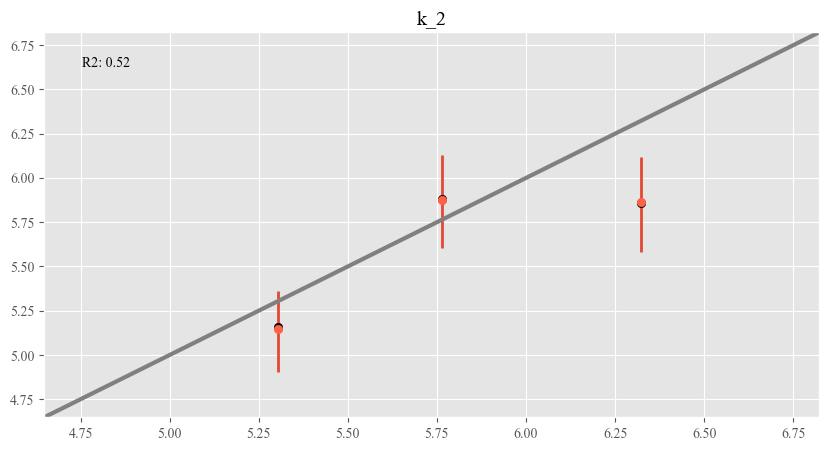

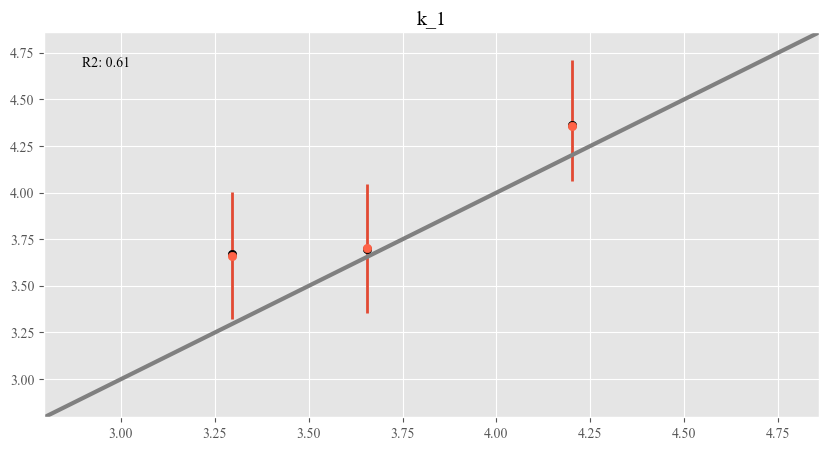

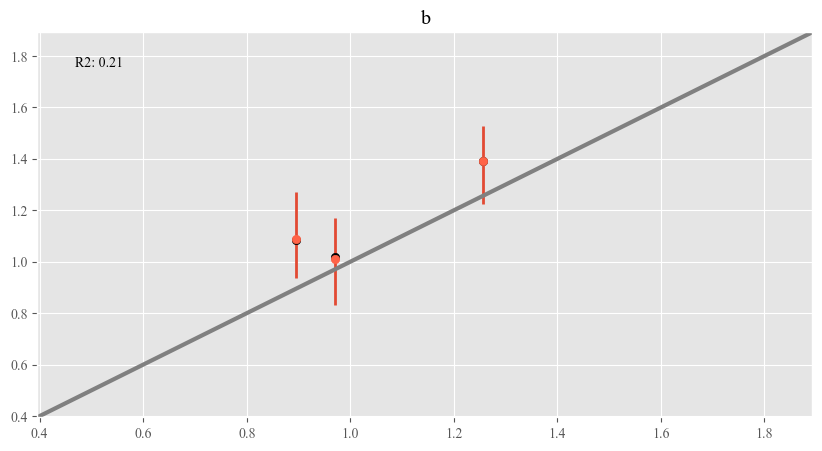

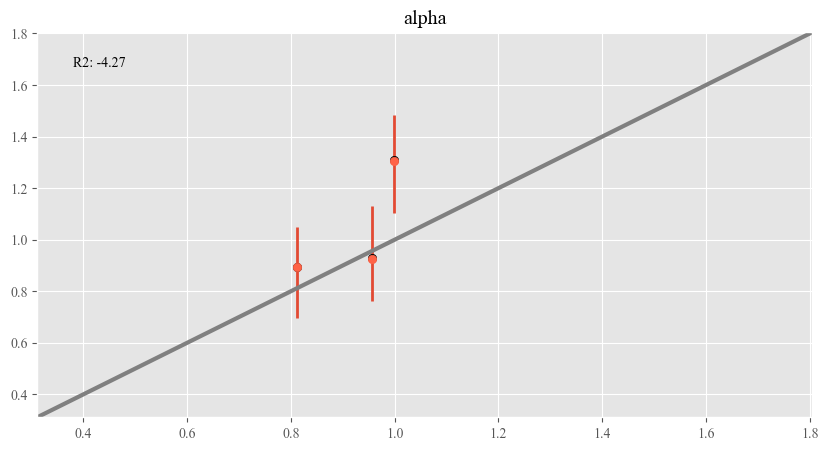

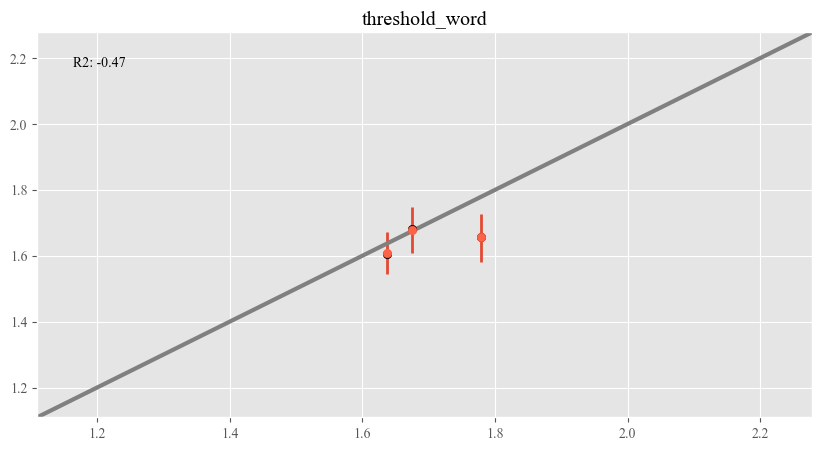

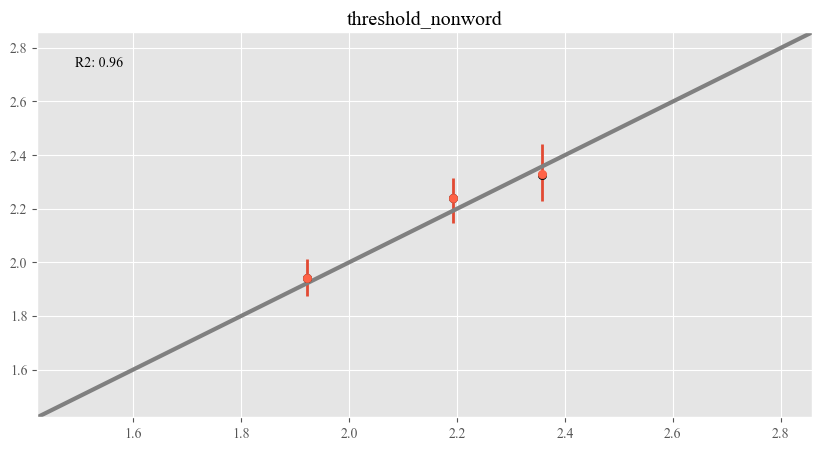

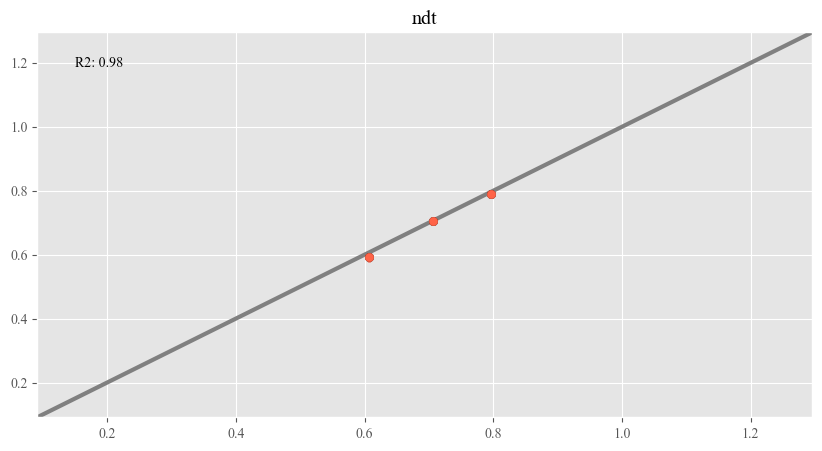

In [6]:
paremeter_recovery()